# Notebook setup

In [31]:
# various pandas, numpy
import pandas as pd
import numpy as np
from pandas_datareader import data as web
from datetime import datetime
import scipy as sp
import scipy.optimize as scopt
import scipy.stats as spstats
import matplotlib.mlab as mlab
# plotting

import matplotlib.pyplot as plt

# make plots inline
%matplotlib inline

# formatting options
pd.set_option('display.notebook_repr_html', False)
pd.set_option('display.max_columns', 7)
pd.set_option('display.max_rows', 10) 
pd.set_option('display.width', 82) 
pd.set_option('precision', 7)

# Modelling of a portfolio with Python and pandas

In [32]:
def create_portfolio(tickers, weights=None):
    if weights is None: 
        shares = np.ones(len(tickers))/len(tickers)
    portfolio = pd.DataFrame({'Tickers': tickers, 
                              'Weights': weights}, 
                              index=tickers)
    return portfolio

In [33]:
portfolio = create_portfolio(['Stock A', 'Stock B'], [1, 1])
portfolio

         Tickers  Weights
Stock A  Stock A        1
Stock B  Stock B        1

In [4]:
returns = pd.DataFrame(
        {'Stock A': [0.1, 0.24, 0.05, -0.02, 0.2],
         'Stock B': [-0.15, -0.2, -0.01, 0.04, -0.15]})
returns

   Stock A  Stock B
0     0.10    -0.15
1     0.24    -0.20
2     0.05    -0.01
3    -0.02     0.04
4     0.20    -0.15

In [34]:

def calculate_weighted_portfolio_value(portfolio, 
                                       returns, 
                                       name='Value'):
    total_weights = portfolio.Weights.sum()
    weighted_returns = returns * (portfolio.Weights / total_weights)
    return pd.DataFrame({name: weighted_returns.sum(axis=1)})

In [35]:
wr = calculate_weighted_portfolio_value(portfolio, 
                                        returns, 
                                        "Value")
with_value = pd.concat([returns, wr], axis=1)
with_value

   Stock A  Stock B  Value
0     0.10    -0.15 -0.025
1     0.24    -0.20  0.020
2     0.05    -0.01  0.020
3    -0.02     0.04  0.010
4     0.20    -0.15  0.025

In [36]:
with_value.std()

Stock A    0.1066771
Stock B    0.1031019
Value      0.0203101
dtype: float64

In [38]:
def plot_portfolio_returns(returns, title=None):
    returns.plot(figsize=(12,8))
    plt.xlabel('Year')
    plt.ylabel('Returns')
    if title is not None: plt.title(title)
    plt.show()
    plt.savefig('5104OS_09_02.png', dpi=300)

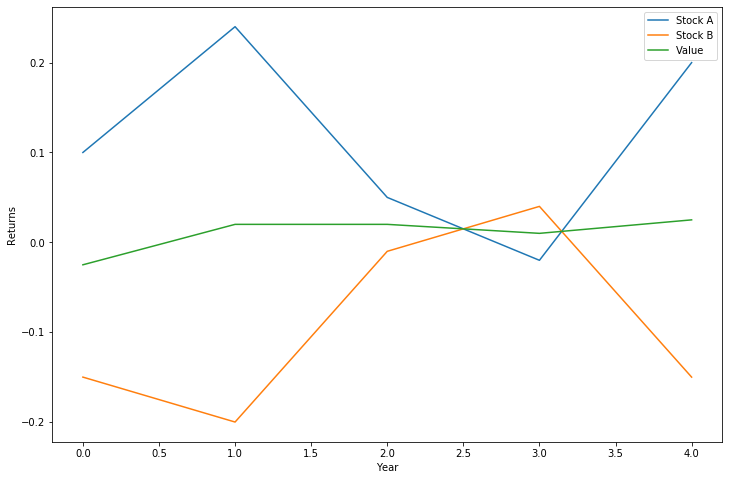

<Figure size 432x288 with 0 Axes>

In [39]:
plot_portfolio_returns(with_value)

In [41]:
returns.corr()

           Stock A    Stock B
Stock A  1.0000000 -0.9255716
Stock B -0.9255716  1.0000000

# Computing an Efficient Portfolio

## Gathering historical returns from Yahoo! Finance

In [58]:
def get_historical_closes(ticker, start_date, end_date):
    # get the data for the tickers.  This will be a panel
    p = web.DataReader(ticker, "yahoo", start_date, end_date)    
    # convert the panel to a DataFrame and selection only Adj Close
    # while making all index levels columns
    print(p)
    d = p['Adj Close'].reset_index()
    print(d)
    # rename the columns
    d.rename(columns={'minor': 'Ticker', 
                      'Adj Close': 'Close'}, inplace=True)
    print(d)
    # pivot each ticker to a column
    #pivoted = d.pivot(index='Date', columns='Ticker')
    # and drop the one level on the columns
    #pivoted.columns = pivoted.columns.droplevel(0)
    #return pivoted

In [59]:
closes = get_historical_closes(['MSFT', 'AAPL', 'KO'], '2010-01-01', '2014-12-31')

Attributes   Adj Close                          ...      Volume               \
Symbols           MSFT        AAPL          KO  ...        MSFT         AAPL   
Date                                            ...                            
2010-01-04  24.0499687   6.5835857  20.2655182  ...  38409100.0  493729600.0   
2010-01-05  24.0577431   6.5949678  20.0203686  ...  49749600.0  601904800.0   
2010-01-06  23.9100971   6.4900656  20.0132656  ...  58182400.0  552160000.0   
2010-01-07  23.6614323   6.4780674  19.9635258  ...  50559700.0  477131200.0   
2010-01-08  23.8246269   6.5211358  19.5940342  ...  51197400.0  447610800.0   
...                ...         ...         ...  ...         ...          ...   
2014-12-24  42.6667900  25.4708252  35.2750587  ...  11437800.0   57918400.0   
2014-12-26  42.4363480  25.9210663  35.2914848  ...  13197800.0  134884000.0   
2014-12-29  42.0552406  25.9028816  35.2093353  ...  14439500.0  110395600.0   
2014-12-30  41.6741257  25.5867996  35.1

In [ ]:
closes[:5]

In [ ]:
def calc_daily_returns(closes):
    return np.log(closes/closes.shift(1))

In [ ]:
# calculate daily returns
daily_returns = calc_daily_returns(closes)
daily_returns[:5]

In [ ]:
# calculate annual returns
def calc_annual_returns(daily_returns):
    grouped = np.exp(daily_returns.groupby(
        lambda date: date.year).sum())-1
    return grouped

In [ ]:
annual_returns = calc_annual_returns(daily_returns)
annual_returns

## Weighted variance co-variance calculation

In [ ]:
def calc_portfolio_var(returns, weights=None):
    if weights is None: 
        weights = np.ones(returns.columns.size) / \
        returns.columns.size
    sigma = np.cov(returns.T,ddof=0)
    var = (weights * sigma * weights.T).sum()
    return var

In [ ]:
# calculate our portfolio variance (equal weighted)
calc_portfolio_var(annual_returns)

## The Sharpe Ratio

In [ ]:
def sharpe_ratio(returns, weights = None, risk_free_rate = 0.015):
    n = returns.columns.size
    if weights is None: weights = np.ones(n)/n
    # get the portfolio variance
    var = calc_portfolio_var(returns, weights)
    # and the means of the stocks in the portfolio
    means = returns.mean()
    # and return the sharpe ratio
    return (means.dot(weights) - risk_free_rate)/np.sqrt(var)

In [ ]:
# calculate equal weighted sharpe ratio
sharpe_ratio(annual_returns)

## Optimization and minimization

In [ ]:
# function to minimize
def y_f(x): return 2+x**2

In [ ]:
scopt.fmin(y_f, 1000)

## Constructing an optimal portfolio 

In [ ]:
def negative_sharpe_ratio_n_minus_1_stock(weights, 
                                          returns, 
                                          risk_free_rate):
    """
    Given n-1 weights, return a negative sharpe ratio
    """
    weights2 = sp.append(weights, 1-np.sum(weights))
    return -sharpe_ratio(returns, weights2, risk_free_rate)

In [ ]:
def optimize_portfolio(returns, risk_free_rate):
    """ 
    Performs the optimization
    """
    # start with equal weights
    w0 = np.ones(returns.columns.size-1, 
                 dtype=float) * 1.0 / returns.columns.size
    # minimize the negative sharpe value
    w1 = scopt.fmin(negative_sharpe_ratio_n_minus_1_stock, 
                    w0, args=(returns, risk_free_rate))
    # build final set of weights
    final_w = sp.append(w1, 1 - np.sum(w1))
    # and calculate the final, optimized, sharpe ratio
    final_sharpe = sharpe_ratio(returns, final_w, risk_free_rate)
    return (final_w, final_sharpe)

In [ ]:
# optimize our portfolio
optimize_portfolio(annual_returns, 0.0003)

# Visualizing the Efficient Frontier

In [ ]:
def objfun(W, R, target_ret):
    stock_mean = np.mean(R,axis=0)
    port_mean = np.dot(W,stock_mean) # portfolio mean
    cov=np.cov(R.T) # var-cov matrix
    port_var = np.dot(np.dot(W,cov),W.T) # portfolio variance
    penalty = 2000*abs(port_mean-target_ret)# penalty 4 deviation
    return np.sqrt(port_var) + penalty # objective function

In [ ]:
def calc_efficient_frontier(returns):
    result_means = []
    result_stds = []
    result_weights = []
    
    means = returns.mean()
    min_mean, max_mean = means.min(), means.max()
    
    nstocks = returns.columns.size
    
    for r in np.linspace(min_mean, max_mean, 100):
        weights = np.ones(nstocks)/nstocks
        bounds = [(0,1) for i in np.arange(nstocks)]
        constraints = ({'type': 'eq', 
                        'fun': lambda W: np.sum(W) - 1})
        results = scopt.minimize(objfun, weights, (returns, r), 
                                 method='SLSQP', 
                                 constraints = constraints,
                                 bounds = bounds)
        if not results.success: # handle error
            raise Exception(results.message)
        result_means.append(np.round(r,4)) # 4 decimal places
        std_=np.round(np.std(np.sum(returns*results.x,axis=1)),6)
        result_stds.append(std_)
        
        result_weights.append(np.round(results.x, 5))
    return {'Means': result_means, 
            'Stds': result_stds, 
            'Weights': result_weights}

In [ ]:
# calculate our frontier
frontier_data = calc_efficient_frontier(annual_returns)

In [ ]:
# first five risk levels
frontier_data['Stds'][:5]

In [ ]:
# first five mean returns
frontier_data['Means'][:5]

In [ ]:
# first five sets of optimal weights
frontier_data['Weights'][:5]

In [ ]:
def plot_efficient_frontier(frontier_data):
    plt.figure(figsize=(12,8))
    plt.title('Efficient Frontier')
    plt.xlabel('Standard Deviation of the porfolio (Risk))')
    plt.ylabel('Return of the portfolio')
    plt.plot(frontier_data['Stds'], frontier_data['Means'], '--'); 
    plt.savefig('5104OS_09_20.png', bbox_inches='tight', dpi=300)

In [ ]:
plot_efficient_frontier(frontier_data)

# Value At Risk

In [ ]:
# get adjusted close values for AAPL in 2014
aapl_closes = get_historical_closes(['AAPL'], 
                                    datetime(2014, 1, 1),
                                    datetime(2014, 12, 31))
aapl_closes[:5]

In [ ]:
# now convert the daily prices to returns
returns = calc_daily_returns(aapl_closes)
returns[:5]

In [ ]:
# plot the histogram of returns
plt.figure(figsize=(12,8))
plt.hist(returns.values[1:], bins=100);
plt.savefig('5104OS_09_23.png', bbox_inches='tight', dpi=300)

In [ ]:
# get the z-score for 95%
z = spstats.norm.ppf(0.95)
z

In [ ]:
# our position is 1000 shares of AAPL at the price
# on 2014-22-31
position = 1000 * aapl_closes.ix['2014-12-31'].AAPL
position

In [ ]:
# what is our VaR
VaR = position * (z * returns.AAPL.std())
VaR

# Misc

In [ ]:
# draw a 99% one-tail confidence interval
x = np.linspace(-4,4,101)
y = np.exp(-x**2/2) / np.sqrt(2*np.pi)
x2 = np.linspace(-4,-2.33,101)
y2 = np.exp(-x2**2/2) / np.sqrt(2*np.pi)
f = plt.figure(figsize=(12,8))
plt.plot(x,y*100, linewidth=2)
xf, yf = mlab.poly_between(x2, 0*x2, y2*100)
plt.fill(xf, yf, facecolor='g', alpha=0.5)
plt.gca().set_xlabel('z-score')
plt.gca().set_ylabel('Frequency %')
plt.title("VaR based on the standard normal distribution")
bbox_props = dict(boxstyle="rarrow,pad=0.3", fc="w", ec="b", lw=2)
t = f.text(0.25, 0.35, "99% VaR confidence level", ha="center", va="center", 
           rotation=270,
            size=15,
            bbox=bbox_props)
plt.savefig('5104OS_09_21.png', bbox_inches='tight', dpi=300)